In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be installed via pip or conda.
# for more details, see: https://github.com/matplotlib/ipympl
%matplotlib widget

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

import time
import datetime

In [2]:
# flags to activate/deactivate temperature measurement sources
ENABLED_KEYSIGHT_DMM = True
ENABLED_DS18B20_GPIO = True
ENABLED_BME280_I2C = True

# initialize the array storing the labels of temperature measurement sources
temp_measurement_sources_arr = []

In [3]:
if ENABLED_KEYSIGHT_DMM:
    KEYSIGHT_IP = '192.168.12.150'
    #KEYSIGHT_IP = '192.168.10.113'
    KEYSIGHT_TEMP_CONF = '01_PT100_4WIRE'
    KEYSIGHT_TEMP_LABEL = 'Sensor 1: Pt100-4wire @Keysight'
    
    temp_measurement_sources_arr.append(KEYSIGHT_TEMP_LABEL)

In [4]:
if ENABLED_BME280_I2C:
    # i2c bus device /dev/i2c-11 or /dev/i2c-22
    BME280_I2C_BUS_DEV = 22
    # i2c address of BME280 on i2c bus
    BME280_I2C_ADDR = 0x76
    BME280_TEMP_LABEL = 'Sensor 2: BME280 @I2C'
    
    temp_measurement_sources_arr.append(BME280_TEMP_LABEL)

In [5]:
if ENABLED_DS18B20_GPIO:
    DS18B20_GPIO_TEMP_LABEL_1 = 'Sensor 3: DS18B20 @GPIO'
    DS18B20_GPIO_TEMP_LABEL_2 = 'Sensor 4: DS18B20 @GPIO'
    
    temp_measurement_sources_arr.append(DS18B20_GPIO_TEMP_LABEL_1)
    temp_measurement_sources_arr.append(DS18B20_GPIO_TEMP_LABEL_2)

In [6]:
temp_measurement_sources_arr

['Sensor 1: Pt100-4wire @Keysight',
 'Sensor 2: BME280 @I2C',
 'Sensor 3: DS18B20 @GPIO',
 'Sensor 4: DS18B20 @GPIO']

In [ ]:
if ENABLED_KEYSIGHT_DMM:
    # import wrapper class PyVisa_Keysight_34465A from python file PyVisa_Keysight_34465A_class.py
    # from ../PyVisa_Keysight_34465A_class.py import PyVisa_Keysight_34465A

    # class PyVisa_Keysight_34465A has to imported via importlib due to different path of notebook and class file
    import importlib.util

    spec = importlib.util.spec_from_file_location("PyVisa_Keysight_34465A", "./PyVisa_Keysight_34465A_class.py")
    keysight_class = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(keysight_class)

In [8]:
if ENABLED_DS18B20_GPIO:
    from w1thermsensor import W1ThermSensor, Sensor

In [11]:
if ENABLED_BME280_I2C:
    import smbus2
    import bme280

In [10]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # add a row
    df.loc[-1] = row
    
    # shift the index
    df.index = df.index + 1
    
    # reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

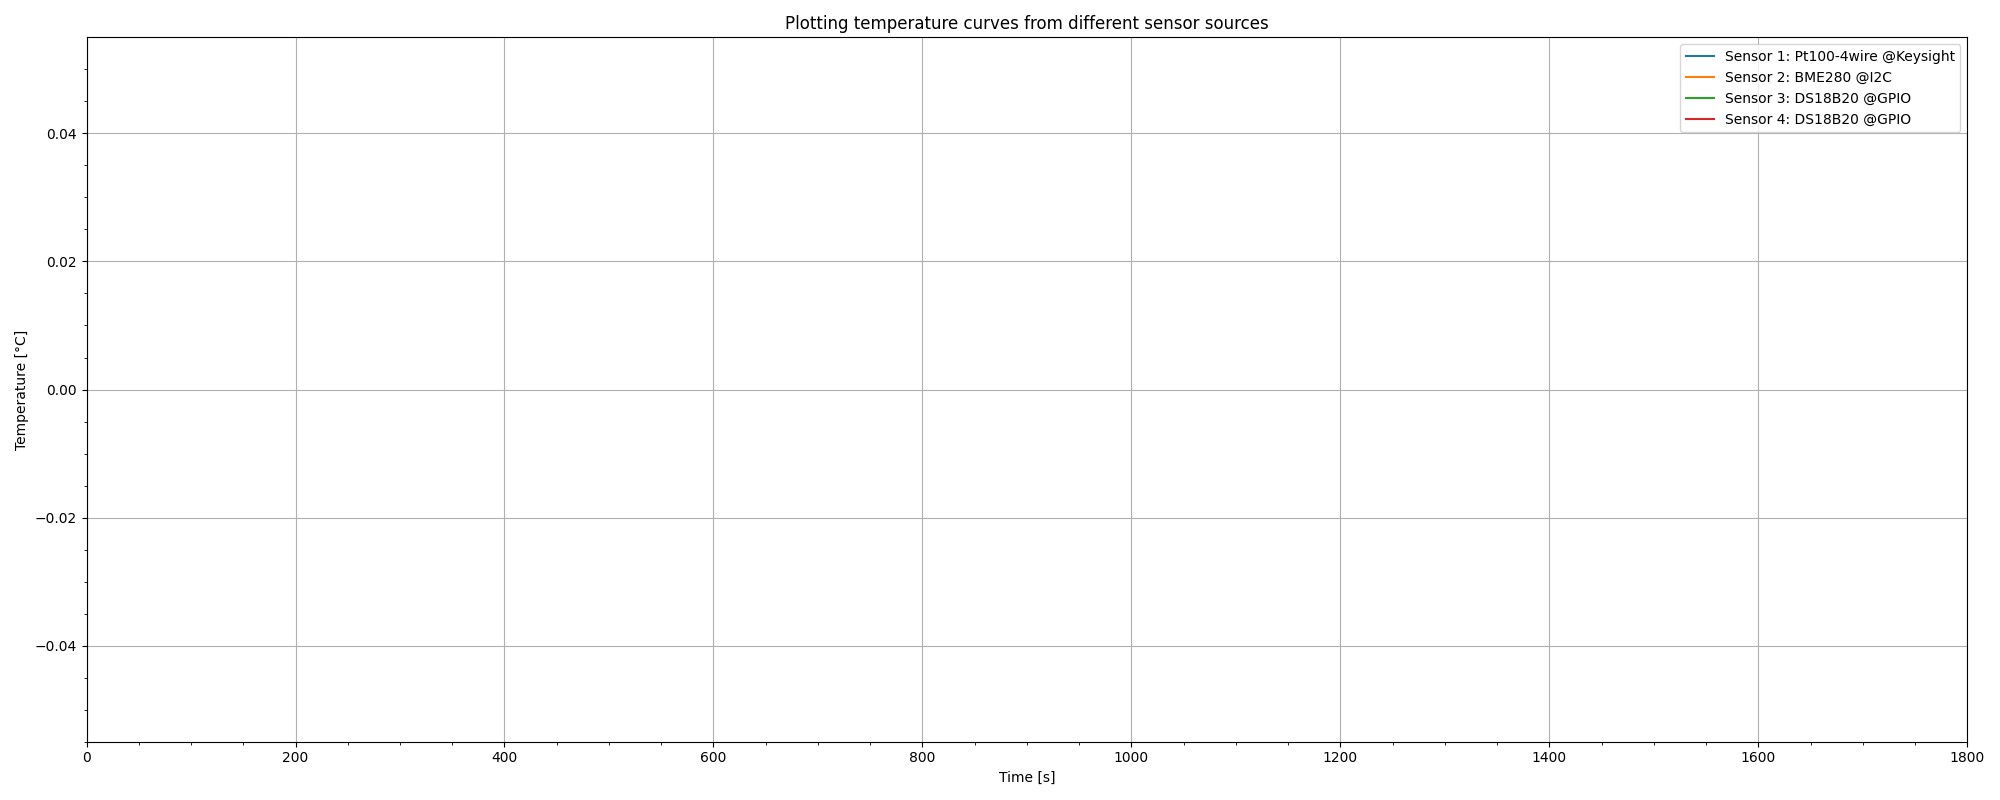

In [97]:
INTERVAL = 0.5

if ENABLED_DS18B20_GPIO:
    # connect to DS18B20 sensors
    sensor_obj = W1ThermSensor()
    sensor_list = sensor_obj.get_available_sensors([Sensor.DS18B20])
    
    # initialization of the temperature array in size according to the number of sensors
    temp_array = np.empty(len(sensor_list), dtype=object)

if ENABLED_KEYSIGHT_DMM:
    # create new device object for the digital multimeter (DMM) Keysight 34465A
    dmm = keysight_class.PyVisa_Keysight_34465A(tcp_ip = KEYSIGHT_IP)

    # configure Keysight DMM for temperature measurement with a valid configuration
    dmm.confTempMeasure(KEYSIGHT_TEMP_CONF)

if ENABLED_BME280_I2C:
    i2c_bus_dev = smbus2.SMBus(BME280_I2C_BUS_DEV)
    bme280_calibration_params = bme280.load_calibration_params(i2c_bus_dev, BME280_I2C_ADDR)
    
# get starting time
time_start_sec = float("{:.2f}".format(time.time()))

# initialize the dataframe that will store the measured values using the column labels of activated temperature measurement sources
df_meas_values = pd.DataFrame(columns=['Time [s]'])

for idx, label in enumerate(temp_measurement_sources_arr):
    df_meas_values.insert(idx+1, label+' [°C]', '')

plt.ioff()

fig, ax = plt.subplots(figsize=(20,8))
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'

plt.title('Plotting temperature curves from different sensor sources')

# define the limits of the x-axis in seconds, from when the canvas should be scrolled
xlim_left = 0
#xlim_span = 600  # 10 minutes
xlim_span = 1800 # 0.5 h
xlim_right = xlim_left + xlim_span
xlim_scroll = xlim_span - 10

ax.set_xlim(xlim_left, xlim_right)

# create list of line objects
line_objects_arr = []
for idx, val in enumerate(temp_measurement_sources_arr):
    line_objects_arr.append('line_temp_'+str(idx))

# dynamically create line objects by list
for idx, val in enumerate(line_objects_arr):
    line_objects_arr[idx], = ax.plot(df_meas_values['Time [s]'], df_meas_values[temp_measurement_sources_arr[idx]+' [°C]'], label=temp_measurement_sources_arr[idx])

ax.grid(True)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Temperature [°C]')
ax.minorticks_on()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.legend()
plt.tight_layout()

fig.canvas.draw()
fig.canvas.flush_events()

display(fig.canvas)

In [102]:
#display(fig.canvas)

while True:
    try:
        # Get time relative to starting time and round to 2 decimals
        timestamp_sec = float("{:.2f}".format(time.time() - time_start_sec))
        # convert timestamp in seconds to human readable time string
        timestamp_str = str(datetime.timedelta(seconds=timestamp_sec))

        values_row = [timestamp_sec]
        
        if ENABLED_KEYSIGHT_DMM:
            # retrieve temperature values from Keysight DMM
            temp_dmm = dmm.getMeasurement()
            print("<{}>\t Pt100 Temperature: {:.7f} °C".format(timestamp_str, temp_dmm))
            values_row.append(temp_dmm)
            
        if ENABLED_BME280_I2C:
            # the sample method will take a single reading and return
            # a compensated_reading object
            bme280_data = bme280.sample(i2c_bus_dev, BME280_I2C_ADDR, bme280_calibration_params)
            print("<{}>\t BME280 Temperature: {:.7f} °C".format(timestamp_str, bme280_data.temperature))
            values_row.append(bme280_data.temperature)
        
        if ENABLED_DS18B20_GPIO:
            i = 0
            for sensor in sensor_list:
                temp_array[i] = sensor.get_temperature()
                print("<{}>\t DS18B20 Sensor: {:d} of {:d}, Temperature: {:.3f} °C, ID: {}".format(timestamp_str, i+1, len(sensor_list), temp_array[i], sensor.id))
                values_row.append(temp_array[i])
                i += 1

        dataframe_add_row(df_meas_values, values_row)

        # when the right edge of the canvas is reached, the canvas should continue to scroll to the left
        xlim_right = datetime.timedelta(seconds=df_meas_values['Time [s]'][0]) + datetime.timedelta(seconds=xlim_scroll)
        if (timestamp_sec >= xlim_right.total_seconds()):
            # drop first row of dataframe
            df_meas_values.drop(index=df_meas_values.head(1).index, inplace=True)
            # reset index of dataframe
            df_meas_values.reset_index(inplace=True, drop=True)

            # take the new first time value for the left boundary of the x-axis
            xlim_left = df_meas_values['Time [s]'][0]
            xlim_right = xlim_left + xlim_span
            ax.set_xlim(xlim_left, xlim_right)

        # Manual scaling of the y-axis
        #
        # get MIN and MAX values of the whole dataframe
        min_val_series = df_meas_values.min()
        max_val_series = df_meas_values.max()
        # drop first elements of the series, because it's the time in seconds and not relevant
        min_val_series.drop(min_val_series.index[0], inplace=True)
        max_val_series.drop(max_val_series.index[0], inplace=True)
        # add some space beneath min value and above max value (in °C)
        ylim_min = min_val_series.min() - 1.5
        ylim_max = max_val_series.max() + 1.5
        # set new scale of y-axis
        ax.set_ylim(ylim_min, ylim_max)
        
        # iterate over the list holding the line objects and set new x- and y-values
        for idx, val in enumerate(line_objects_arr):
            line_objects_arr[idx].set_xdata(df_meas_values['Time [s]'])
            line_objects_arr[idx].set_ydata(df_meas_values[temp_measurement_sources_arr[idx4]+' [°C]'])

        #ax.relim()
        #ax.autoscale_view()

        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(INTERVAL)
        
    except:
        print("Keyboard Interrupt ^C detected.")
        print("Bye.")
        break

<0:06:41.360000>	 Pt100 Temperature: 22.7243895 °C
<0:06:41.360000>	 BME280 Temperature: 18.7801051 °C
<0:06:41.360000>	 DS18B20 Sensor: 1 of 2, Temperature: 23.750 °C, ID: 012116c9fc70
<0:06:41.360000>	 DS18B20 Sensor: 2 of 2, Temperature: 24.500 °C, ID: 01202ceb55a3
<0:06:44.680000>	 Pt100 Temperature: 22.6657987 °C
<0:06:44.680000>	 BME280 Temperature: 18.7698445 °C
<0:06:44.680000>	 DS18B20 Sensor: 1 of 2, Temperature: 23.688 °C, ID: 012116c9fc70
<0:06:44.680000>	 DS18B20 Sensor: 2 of 2, Temperature: 24.438 °C, ID: 01202ceb55a3
<0:06:47.880000>	 Pt100 Temperature: 22.6192892 °C
<0:06:47.880000>	 BME280 Temperature: 18.7544536 °C
<0:06:47.880000>	 DS18B20 Sensor: 1 of 2, Temperature: 23.625 °C, ID: 012116c9fc70
<0:06:47.880000>	 DS18B20 Sensor: 2 of 2, Temperature: 24.375 °C, ID: 01202ceb55a3
<0:06:51.080000>	 Pt100 Temperature: 22.5756501 °C
<0:06:51.080000>	 BME280 Temperature: 18.7544536 °C
<0:06:51.080000>	 DS18B20 Sensor: 1 of 2, Temperature: 23.562 °C, ID: 012116c9fc70
<0:06:5

KeyboardInterrupt: 

In [22]:
df_meas_values

,Time [s],Sensor 1: Pt100-4wire @Keysight [°C],Sensor 2: BME280 @I2C [°C],Sensor 3: DS18B20 @GPIO [°C],Sensor 4: DS18B20 @GPIO [°C]
0,3907.60,19.388493,18.251685,18.8750,18.875
1,3910.92,19.387305,18.241424,18.8750,18.875
2,3914.29,19.387154,18.251685,18.8750,18.875
3,3917.66,19.386471,18.251685,18.8750,18.875
4,3921.02,19.385081,18.246555,18.8750,18.875
...,...,...,...,...,...
550,5761.88,19.039768,18.651848,18.6875,18.500
551,5765.21,19.040488,18.610805,18.6875,18.500
552,5768.61,19.040849,18.600545,18.6875,18.500
553,5771.99,19.040644,18.615935,18.6875,18.500
